# Introduction

This notebook is all about running image segmentation through U-Net, one of the most popular convolutional neural network (CNN) architectures specially designed for segmentation tasks.


## Import All Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



Let us do a quick check to see if our Deep Learning Libraries are installed and running through our local machine:

In [2]:
# If there's a GPU available...
import torch
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1660 Ti with Max-Q Design


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In the case where Pytorch is not recognizing your GPU, please run the code below in your command prompt (CMD) to upgrade torch:

In [4]:
#!pip3 install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

Let us start by defining the path / directory towards our images. These are divided into 3 categories: train, test, and validation. It is of note that the only pre-processing step needed is resizing the images into 128 x 128 x 3, and the masks into 128 x 128 x 1. This step is already done before running this notebook, but you can resize the image by running "resize.py" after modifying the directories.

In [5]:
import os
from PIL import Image
from skimage.io import imshow

In [6]:
# Load training images and their respective masks
# state image sizes
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

IMAGE_TRAIN_PATH = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/ISIC Data/train/ISIC-2017_Training_Data"
MASK_TRAIN_PATH = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/ISIC Data/train/ISIC-2017_Training_Part1_GroundTruth"
IMAGE_PRED_PATH = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/ISIC Data/test/ISIC-2017_Test_v2_Data"
MASK_PRED_PATH = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/ISIC Data/test/ISIC-2017_Test_v2_Part1_GroundTruth"
IMAGE_VAL_PATH = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/ISIC Data/val/ISIC-2017_Validation_Data"
MASK_VAL_PATH = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/ISIC Data/val/ISIC-2017_Validation_Part1_GroundTruth"


image_train_files = os.listdir(IMAGE_TRAIN_PATH)
mask_train_files = os.listdir(MASK_TRAIN_PATH)
image_pred_files = os.listdir(IMAGE_PRED_PATH)
mask_pred_files = os.listdir(MASK_PRED_PATH)
image_val_files = os.listdir(IMAGE_VAL_PATH)
mask_val_files = os.listdir(MASK_VAL_PATH)

In [7]:
# initiate vectors to store images and masks
X_train = np.zeros((len(image_train_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y_train = np.zeros((len(image_train_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)


In [8]:
for n, image_file in enumerate(image_train_files):
    image_path = os.path.join(IMAGE_TRAIN_PATH, image_file)
    mask_file = image_file.replace('.jpg', '_segmentation.png')
    mask_path = os.path.join(MASK_TRAIN_PATH, mask_file)

    image = Image.open(image_path)
    mask = Image.open(mask_path)

    # store images and masks
    X_train[n] = np.array(image)
    y_train[n] = np.expand_dims(np.array(mask), axis=-1)

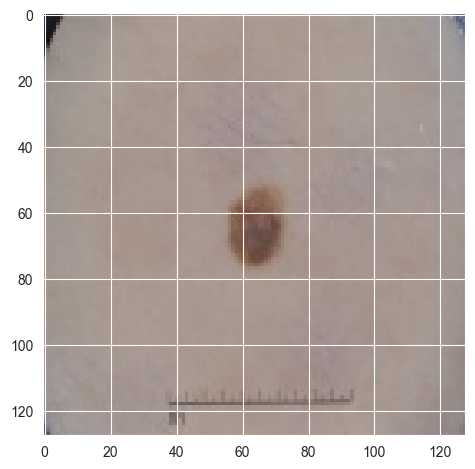

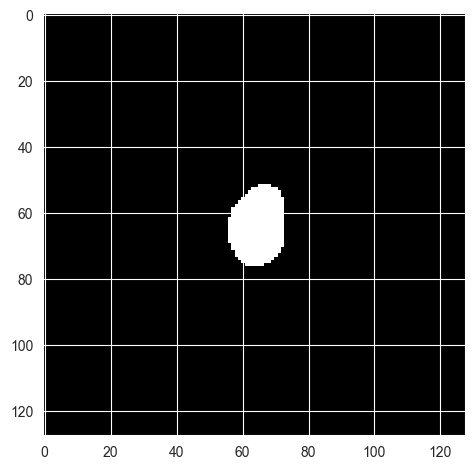

In [9]:
# sanity check
import random
image_x = random.randint(0, len(X_train))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(y_train[image_x]))
plt.show()

In [10]:
# Load test images
# initiate vector to store test images
X_test = np.zeros((len(image_pred_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y_test = np.zeros((len(image_pred_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
print('Loading test images')

Loading test images


In [11]:
for n, test_image_file in enumerate(image_pred_files):
    image_path_test = os.path.join(IMAGE_PRED_PATH, test_image_file)
    mask_file_test = test_image_file.replace('.jpg', '_segmentation.png')
    mask_path_test = os.path.join(MASK_PRED_PATH, mask_file_test)

    image_test = Image.open(image_path_test)
    mask_test = Image.open(mask_path_test)

    # store images and masks
    X_test[n] = np.array(image_test)
    y_test[n] = np.expand_dims(np.array(mask_test), axis=-1)

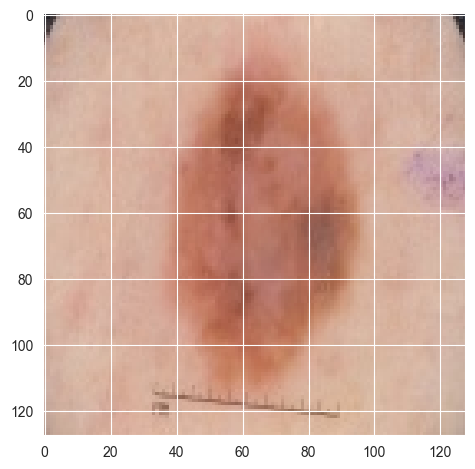

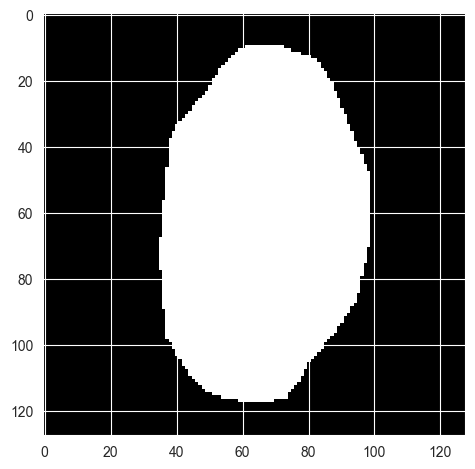

In [12]:
image1_x = random.randint(0, len(X_test))
imshow(X_test[image1_x])
plt.show()
imshow(np.squeeze(y_test[image1_x]))
plt.show()

In [13]:
# Load validation images
# initiate vector to store test images
X_val = np.zeros((len(image_val_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y_val = np.zeros((len(image_val_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
print('Loading validation images')

Loading validation images


In [14]:
for n, val_image_file in enumerate(image_val_files):
    image_path_val = os.path.join(IMAGE_VAL_PATH, val_image_file)
    mask_file_val = val_image_file.replace('.jpg', '_segmentation.png')
    mask_path_val = os.path.join(MASK_VAL_PATH, mask_file_val)

    image_val = Image.open(image_path_val)
    mask_val = Image.open(mask_path_val)

    # store images and masks
    X_val[n] = np.array(image_val)
    y_val[n] = np.expand_dims(np.array(mask_val), axis=-1)

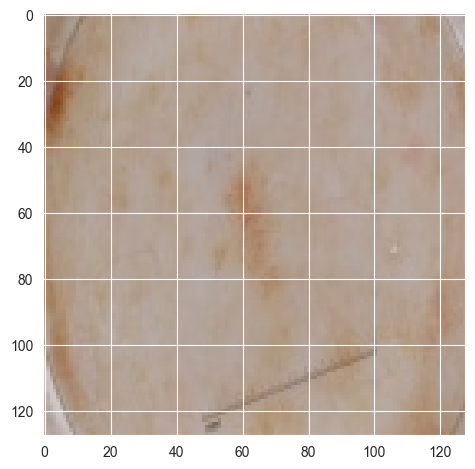

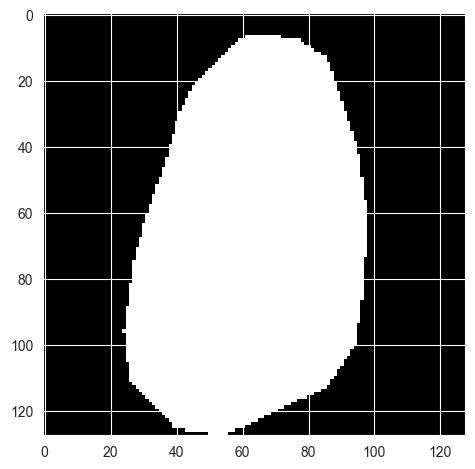

In [15]:
image2_x = random.randint(0, len(X_val))
imshow(X_val[image2_x])
plt.show()
imshow(np.squeeze(y_test[image2_x]))
plt.show()

With the dataset ready, the next step is to build the U-Net model for testing.

# U-net architecture

To build the U-Net model, the deep learning library used will be Tensorflow-Keras. Let us now start building the model:

In [16]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

In [17]:
kernel_initializer = 'he_normal'

What makes U-Net unique is the way the CNN model is designed. It essentially has 2 paths:

1.) Contraction - It downsamples the dimensions, while increasing the number of features until such time it becomes "flat".

2.) Expansion - It does the contraction, but in reverse. It now upsamples the data until it reaches the original image dimension. The said output of this would be a mask created from predictions.

The code for building the model is shown below (we used the CSV method for this):

In [18]:
#Contraction path

c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

In [19]:
#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

In [20]:
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [21]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

It is now time to run and train the U-Net model over a set number of epochs. Please note that this can be changed based on the specific needs / requirements of the project.

In [22]:
# Model checkpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_unet.keras', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
125/125 [==============================] - 16s 54ms/step - loss: 0.3939 - accuracy: 0.8341 - val_loss: 0.3283 - val_accuracy: 0.8706
Epoch 2/25
125/125 [==============================] - 6s 47ms/step - loss: 0.2832 - accuracy: 0.8944 - val_loss: 0.2800 - val_accuracy: 0.8943
Epoch 3/25
125/125 [==============================] - 6s 47ms/step - loss: 0.1997 - accuracy: 0.9286 - val_loss: 0.2526 - val_accuracy: 0.8987
Epoch 4/25
125/125 [==============================] - 6s 47ms/step - loss: 0.1584 - accuracy: 0.9423 - val_loss: 0.2295 - val_accuracy: 0.9100
Epoch 5/25
125/125 [==============================] - 6s 48ms/step - loss: 0.1459 - accuracy: 0.9463 - val_loss: 0.2722 - val_accuracy: 0.8997
Epoch 6/25
125/125 [==============================] - 6s 48ms/step - loss: 0.1442 - accuracy: 0.9462 - val_loss: 0.2589 - val_accuracy: 0.9037


In [23]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_unet.keras', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=100, callbacks=callbacks)

Epoch 1/100
125/125 [==============================] - 6s 48ms/step - loss: 0.1279 - accuracy: 0.9517 - val_loss: 0.2474 - val_accuracy: 0.9118
Epoch 2/100
125/125 [==============================] - 6s 48ms/step - loss: 0.1281 - accuracy: 0.9511 - val_loss: 0.2210 - val_accuracy: 0.9215
Epoch 3/100
125/125 [==============================] - 6s 48ms/step - loss: 0.1235 - accuracy: 0.9530 - val_loss: 0.2574 - val_accuracy: 0.9084
Epoch 4/100
125/125 [==============================] - 6s 48ms/step - loss: 0.1177 - accuracy: 0.9540 - val_loss: 0.2188 - val_accuracy: 0.9149
Epoch 5/100
125/125 [==============================] - 6s 48ms/step - loss: 0.1161 - accuracy: 0.9547 - val_loss: 0.2383 - val_accuracy: 0.9135
Epoch 6/100
125/125 [==============================] - 6s 48ms/step - loss: 0.1070 - accuracy: 0.9581 - val_loss: 0.2684 - val_accuracy: 0.9153
Epoch 7/100
125/125 [==============================] - 6s 48ms/step - loss: 0.1096 - accuracy: 0.9575 - val_loss: 0.2224 - val_accuracy:

With the training done, let us now use the trained model to predict on our test data:

In [34]:
# prediction
predicted_mask = model.predict(X_test)
train_predicted_mask = model.predict(X_train)
val_predicted_mask = model.predict(X_val)

5/5 [==============================] - 0s 20ms/step


The threshold of the prediction in this case is set to > 0.5. This means that any masks that have a predicted value of < = 0.5 will not be shown.

In [35]:
mask_train_thresh = (train_predicted_mask > 0.5)
mask_val_thresh =  (val_predicted_mask > 0.5)
mask_pred_thresh = (predicted_mask > 0.5)

Let us now compare the predicted segmented mask with the actual mask (ground truth):

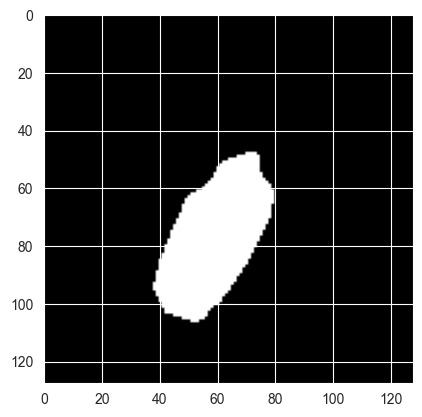

In [36]:
# Show the predicted segment
plt.imshow(mask_pred_thresh[1], cmap='gray')

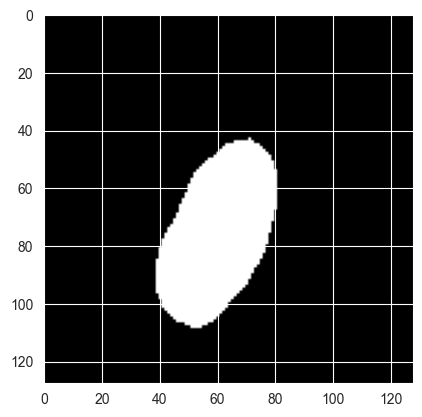

In [37]:
# Actual result
plt.imshow(y_test[1], cmap='gray')

# Evaluation of U-net architecture

A good way to evaluate for accuracy would be the dice coefficient. The dice coefficient is a measure of similarity between the ground truth and the segmented image. This coefficient ranges from 0-1, and the higher the coefficient, the higher the accuracy as a result.

In [28]:
# Function to establish the Dice Coefficient
def dice_coefficient(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    intersection_count = np.sum(intersection)
    y_true_count = np.sum(y_true)
    y_pred_count = np.sum(y_pred)

    dice = (2.0 * intersection_count) / (y_true_count + y_pred_count)

    return dice

In [29]:
# Compute Dice Coefficient
dice = dice_coefficient(y_test, mask_pred_thresh)
print("Dice Coefficient:", dice)

Dice Coefficient: 0.7642586528345837


Another common measure would be the Intersection over Union (IoU), or the Jaccard Index. As the term implies, this pertains how accurate is the overlap between the predicted mask and the ground truth. This coefficient ranges from 0-1, and the higher the coefficient, the higher the accuracy.

In [30]:
# Function to establish the Jaccard Index
def compute_jaccard_index(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)

    jaccard_index = np.sum(intersection) / np.sum(union)

    return jaccard_index


In [31]:
jaccard_index = compute_jaccard_index(y_test, mask_pred_thresh)
print("Jaccard Index:", jaccard_index)

Jaccard Index: 0.6184616664220755


Another common measure is sensitivity and specificity:

In [32]:
# Define function to return sensitivity and specificity
from sklearn.metrics import confusion_matrix

def compute_sensitivity_specificity(y_true, y_pred):
    # Flatten masks
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Confusion Matrix
    cm = confusion_matrix(y_true_flat, y_pred_flat)

    # Extract TP, TN, FP, FN
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]

    # Calculate sensitivity and specificity
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    return sensitivity, specificity

In [33]:
sensitivity, specificity = compute_sensitivity_specificity(y_test, mask_pred_thresh)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Sensitivity: 0.6374610713879442
Specificity: 0.9899333672241728


With the segmentation done, let us now proceed with saving our directories accordingly. It is of note here that I renamed the image_ids, as I have verified that they follow the same order.

In [35]:
import cv2
import os

# Create directories for segmented images and predicted masks
save_directory_segmented_train = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/segmented_images/train"
save_directory_segmented_test = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/segmented_images/test"
save_directory_segmented_val = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/segmented_images/val"
save_directory_masks_train = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/predicted_masks/train"
save_directory_masks_test = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/predicted_masks/test"
save_directory_masks_val = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/predicted_masks/val"

# Saving segmented images for the training set
for i, image in enumerate(X_train):
    filename = f"ISIC_{i}.jpg"
    save_path = os.path.join(save_directory_segmented_train, filename)
    cv2.imwrite(save_path, image)

# Saving segmented images for the validation set
for i, image in enumerate(X_val):
    filename = f"ISIC_{i}.jpg"
    save_path = os.path.join(save_directory_segmented_val, filename)
    cv2.imwrite(save_path, image)

# Saving segmented images for the test set
for i, image in enumerate(X_test):
    filename = f"ISIC_{i}.jpg"
    save_path = os.path.join(save_directory_segmented_test, filename)
    cv2.imwrite(save_path, image)

# Saving predicted masks for the training set
for i, mask in enumerate(mask_train_thresh):
    filename = f"ISIC_{i}_segmentation.jpg"
    save_path = os.path.join(save_directory_masks_train, filename)
    cv2.imwrite(save_path, mask * 255)  # Adjust the range if necessary

# Saving predicted masks for the validation set
for i, mask in enumerate(mask_val_thresh):
    filename = f"ISIC_{i}_segmentation.jpg"
    save_path = os.path.join(save_directory_masks_val, filename)
    cv2.imwrite(save_path, mask * 255)  # Adjust the range if necessary

# Saving predicted masks for the test set
for i, mask in enumerate(mask_pred_thresh):
    filename = f"ISIC_{i}_segmentation.jpg"
    save_path = os.path.join(save_directory_masks_test, filename)
    cv2.imwrite(save_path, mask * 255)  # Adjust the range if necessary


Since this is a multi-classification problem, we will need to modify the ground truth csv file to make sure this can take in multiple values so we can feed it to our classification algorithm later on:

In [45]:
# SAVE TRAINING GROUND TRUTH TO SEGMENTED IMAGES
# Path to csv file
train_csv_file_path = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/ISIC Data/train/ISIC-2017_Training_Part3_GroundTruth.csv"

# Path to the new folder where the CSV file will be saved
train_output_folder = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/segmented_images/train"

# Read CSV file
df = pd.read_csv(train_csv_file_path)

# Create the third column based on conditions
df['class'] = 2  # Initialize with class 2 (others)
df.loc[(df['melanoma'] == 1) & (df['seborrheic_keratosis'] == 0), 'class'] = 0  # Melanoma class
df.loc[(df['melanoma'] == 0) & (df['seborrheic_keratosis'] == 1), 'class'] = 1  # Keratosis class

# Create the output file path
output_file_path = train_output_folder + 'classes_train.csv'

# Add a new column 'image_id' with the desired values
df['image_id'] = 'ISIC_' + df.index.astype(str)

# Save the modified DataFrame as a new CSV file
df.to_csv(output_file_path, index=False)


In [2]:
# SAVE TESTING GROUND TRUTH TO SEGMENTED IMAGES
# Path to csv file
test_csv_file_path = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/ISIC Data/test/ISIC-2017_Test_v2_Part3_GroundTruth.csv"

# Path to the new folder where the CSV file will be saved
test_output_folder = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/segmented_images/test"

# Read CSV file
df = pd.read_csv(test_csv_file_path)

# Create the third column based on conditions
df['class'] = 2  # Initialize with class 2 (others)
df.loc[(df['melanoma'] == 1) & (df['seborrheic_keratosis'] == 0), 'class'] = 0  # Melanoma class
df.loc[(df['melanoma'] == 0) & (df['seborrheic_keratosis'] == 1), 'class'] = 1  # Keratosis class

# Create the output file path
output_file_path = test_output_folder + 'classes_test.csv'

# Add a new column 'image_id' with the desired values
df['image_id'] = 'ISIC_' + df.index.astype(str)

# Save the modified DataFrame as a new CSV file
df.to_csv(output_file_path, index=False)

In [51]:
# SAVE VALIDATION GROUND TRUTH TO SEGMENTED IMAGES
# Path to csv file
val_csv_file_path = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/ISIC Data/val/ISIC-2017_Validation_Part3_GroundTruth.csv"

# Path to the new folder where the CSV file will be saved
val_output_folder = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/segmented_images/val"

# Read CSV file
df = pd.read_csv(val_csv_file_path)

# Create the third column based on conditions
df['class'] = 2  # Initialize with class 2 (others)
df.loc[(df['melanoma'] == 1) & (df['seborrheic_keratosis'] == 0), 'class'] = 0  # Melanoma class
df.loc[(df['melanoma'] == 0) & (df['seborrheic_keratosis'] == 1), 'class'] = 1  # Keratosis class

# Drop the columns
df.drop(['melanoma','seborrheic_keratosis'], axis=1)

# Create the output file path
output_file_path = val_output_folder + 'classes_test.csv'

# Add a new column 'image_id' with the desired values
df['image_id'] = 'ISIC_' + df.index.astype(str)


# Save the modified DataFrame as a new CSV file
df.to_csv(output_file_path, index=False)


PermissionError: [Errno 13] Permission denied: "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/segmented_images/valclasses_test1.csv"

Credits to: Florence Cheng, Simone Marawa, Jency James Paul